# MDN for Inverse Kinematics Data using Keras MDN

The below is an attempt at reproducing the Robot Inverse Kinematics example presented in the incredible [Mixture Density Networks paper (1994) by C. M. Bishop](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.120.5685&rep=rep1&type=pdf) using the [Keras MDN Layer](https://github.com/cpmpercussion/keras-mdn-layer) (which relies [TensorFlow Probability](https://www.tensorflow.org/probability)).

All embedded images are from the 1994 paper itself.

STATUS: Failing to reproduce the Mixture Density Network. But successfully (IMO) reproduced the simple MLP baseline attempted prior to the MDN.

## Boring stuff (imports, some constants and helpers)

In [0]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [2]:
!pip install git+git://github.com/cpmpercussion/keras-mdn-layer.git#egg=keras-mdn-layer

  Cloning git://github.com/cpmpercussion/keras-mdn-layer.git to /tmp/pip-install-565y6hev/keras-mdn-layer
  Stored in directory: /tmp/pip-ephem-wheel-cache-yz6tpgsp/wheels/35/db/18/520cfe0c40ae069c90d5210794d0dc03d3834b92dec8c57d9c
Successfully built keras-mdn-layer


In [3]:
import keras
from keras import backend as K
import mdn

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
DATA_DIR = "mdn_data"
"""Path where synthesized kinematics data will be saved and read from."""

CHECKPOINT_DIR = "mdn_checkpoints"
"""Path where intermediate model checkpoints will be saved and read from.""";

In [0]:
def save_model(sess, ckpt_dir, global_step, log_on):
    """Helper for saving intermediate checkpoint."""
    saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(ckpt_dir, 'gmm_mdn')
    if log_on:
        tf.logging.info('saving model %s.', checkpoint_path)
        tf.logging.info('global_step %i.', global_step)
    saver.save(sess, checkpoint_path, global_step=global_step)
    
def load_checkpoint(sess, ckpt_dir):
    """Helper for loading intermediate checkpoint."""
    saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    
def plot_2d(datas, quiver_lst=[],figsize=(6,6), xlabel='X1', ylabel='X2', s=2,
            q_headaxislength=1, q_units='xy', q_scale=None, aspect_equal=False):
    """Plots each data in datas as 2d scatter."""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for data in datas:
        ax.scatter(data[:,0], data[:,1], s=s)
    if len(quiver_lst) == 2:
        ql = quiver_lst
        ax.quiver(ql[0][:,0], ql[0][:,1], ql[1][:,0], ql[1][:,1],
                  headaxislength=q_headaxislength, units=q_units, scale=q_scale)
    if aspect_equal:
        ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

## Motivation - IK is useful

Consider a 2-link robot arm sitting upright on a base. The first link of length $L_1$ is attached to base via a [revolute joint](https://en.wikipedia.org/wiki/Revolute_joint) at angle $\theta_1$, and the second link of length $L_2$ is similarly attached to the first via another revolute joint at angle $\theta_2$. The position of the end effector is $(x1, x2)$. The below diagram from the paper should help clarify the situation.

![Image of 2-link robot arm](https://i.ibb.co/7GzgnS8/robot-2-link.png)

Typically, the robot arm has to move such that the end effector reaches some specified $(x1, x2)$, say $(1.4,3.3)$. Maybe there is a box there, and we want the arm to grasp it.

The question is - **can we figure out what angles $(\theta_1, \theta_2)$ should be made by the 2 joints so that the end effector reaches a prespecified target position $(x_1, x_2)$?**




## Problem - IK is not easy

If we stare at the problem for a bit, we realize that sometimes for a given target position, we might have two different joint configurations that both achieve the same position. For example, in the image, we can reflect the links in the 'elbow up' configuration across an axis going through the base joint and end effector, and get another valid joint angle pair where the links come in from under in the 'elbow down' configuration.

![image of multi-valued problem in inverse kinematics](https://i.ibb.co/sjZcD7S/robot-2-link-multivalued.png)

So it turns out this problem is not so trivial, because for the same input $(x_1, x_2)$ we have possibly multiple correct outputs $(\theta_1, \theta_2)$. The field of Inverse Kinematics tries to answer this and related problems, and good IK solvers have applications in areas like animation, robotic systems and who knows what else.

How to proceed? Well there are probably numerous ways, but since this is a notebook on Mixture Density Networks, our preferred approach will be to generate lots of examples of $(x_1, x_2)$ and $(\theta_1, \theta_2)$ and try to model the relationship with a neural network :).

Okay great, so how do we generate all those examples?

## FK Is Easy $\rightarrow$ Run FK for Data

Let's assume we can have the answer we want - we have the joint angle $(\theta_1, \theta_2)$. Can we predict the consequent location of the end effector $(x_1, x_2)$? 

This is a much simpler problem, admitting a single output for every input, and the output can be derived from the trigonometric equations of forward kinematics for a 2-link robot arm system!

\begin{array}{rcl} x_1 & = & L_1 cos (\theta_1) - L_2 cos (\theta_1 + \theta_2) \\ x_2 & = & L_1 sin (\theta_1) - L_2 sin (\theta_1 + \theta_2) \end{array}

This is great, because we can just feed different values for the angles into the system of equations to create $N$ training example pairs of  $X_j=(x_1, x_2)_j$ and $Y_j=(\theta_1, \theta_2)_j$, where $j \in (1,N)$.

In [0]:
should_remake_data = True
"""If True, will resynthesize kinematics data."""

N = 3000
"""Number of kinematics data samples to synthesize for training."""

L1 = 0.8
"""Length of the first link of the robot arm (attached to the base)."""

L2 = 0.2
"""Length of the second link of the robot arm (attached to the end effector)"""

theta1_range = (0.3, 1.2)
"""Range of angle values between link 1 and base."""

theta2_range = (0.5*np.pi, 1.5*np.pi)
"""Range of angle values between link 2 and link 1.""";

In [0]:
def fk_solve(theta1, theta2, l1=0.8, l2=0.2):
    x1 = l1*np.cos(theta1) - l2*np.cos(theta1 + theta2)
    x2 = l1*np.sin(theta1) - l2*np.sin(theta1 + theta2)
    return x1, x2

def remake_and_save_data(save_name, n,
                         l1=0.8,
                         l2=0.2,
                         theta1_rng=(0.3,1.2),
                         theta2_rng=(0.5*np.pi, 1.5*np.pi),
                         pick_randly=True):
    """Recreates synthetic kinematics data for a 2-link robot arm."""
    if not os.path.exists(os.path.dirname(save_name)):
        os.makedirs(os.path.dirname(save_name))
    if not pick_randly:
        theta1 = np.linspace(theta1_rng[0], theta1_rng[1], n).reshape(-1,1)
        theta2 = np.linspace(theta2_rng[0], theta2_rng[1], n).reshape(-1,1)
    else:
        theta1 = np.random.uniform(theta1_rng[0], theta1_rng[1], n).reshape(-1,1)
        theta2 = np.random.uniform(theta2_rng[0], theta2_rng[1], n).reshape(-1,1)
    x1, x2 = fk_solve(theta1, theta2, l1, l2)
    theta = np.concatenate([theta1, theta2], axis=1)
    x = np.concatenate([x1, x2], axis=1)
    np.savez(save_name, x=x, theta=theta)

In [0]:
## Initialize data
train_data_path = os.path.join(DATA_DIR, "theta_x_train.npz")
test_data_path = os.path.join(DATA_DIR, "theta_x_test.npz")
if should_remake_data:
    remake_and_save_data(save_name=train_data_path, n=N,
                         l1=L1, l2=L2,
                         theta1_rng=theta1_range, theta2_rng=theta2_range)
    remake_and_save_data(save_name=test_data_path, n=N,
                         l1=L1, l2=L2,
                         theta1_rng=theta1_range, theta2_rng=theta2_range)

# All the train data
all_train_data = np.load(train_data_path, encoding="bytes")
theta_train = all_train_data['theta']
x_train = all_train_data['x']

# All the test data
all_test_data = np.load(test_data_path, encoding="bytes")
theta_test = all_test_data['theta']
x_test = all_test_data['x']

Before we plot the simulated data, let's just note one more thing.

Suppose link 1 is as upright as possible at angle $\max \theta_1$. Imagine the locus of points made by the end effector attached to link 2, as the end effector spins from $\min \theta_2$ to $\max \theta_2$. All the positions $(x_1, x_2)$ achieved by the end effector inside the circle can only be reached by the end effector when link 1's angle is somewhat (but not drastically) less than $\max \theta_1$ and when the arm is in the  'elbow up' configuration.

There is a similar region near the bottom when link 1 is making the lowest possible angle $\min \theta_1$, and the points in the circular region carved out by the end effector here can only be reached by some particular 'elbow down' configuration of the arm.

We make a point to mark these regions in our plots, because here each $(x_1, x_2)$ can only map to one $(\theta_1, \theta_2)$.

In [0]:
def region_indices(data, region='A', l1=0.8, l2=0.2, t1_rng=(0.3,1.2)):
    if region == 'A':
        center = l1*np.cos(t1_rng[1]), l1*np.sin(t1_rng[1])
    else:
        center = l1*np.cos(t1_rng[0]), l1*np.sin(t1_rng[0])
    radius_sqrd = np.square(l2)
    data_c = np.sum(np.square(data - center), axis=1) < radius_sqrd
    return data_c

In [0]:
# A, C regions are where the IK has a single solution. In the rest of 
# the space in the "middle", each (x1,x2) maps to two (theta1, theta2).
regionA_data_path = os.path.join(DATA_DIR, "regionA.npz")
regionC_data_path = os.path.join(DATA_DIR, "regionC.npz")

if should_remake_data:
      remake_and_save_data(save_name=regionA_data_path, n=N,
                           l1=L1, l2=L2,
                           theta1_rng=(theta1_range[1],theta1_range[1]), 
                           theta2_rng=theta2_range,
                           pick_randly=False)
      remake_and_save_data(save_name=regionC_data_path, n=N,
                           l1=L1, l2=L2,
                           theta1_rng=(theta1_range[0],theta1_range[0]), 
                           theta2_rng=theta2_range,
                           pick_randly=False)

x_regionA = np.load(regionA_data_path, encoding="bytes")['x']
x_regionC = np.load(regionC_data_path, encoding="bytes")['x']

region_ids_A = region_indices(x_train, 'A', L1, L2, theta1_range)
region_ids_C = region_indices(x_train, 'C', L1, L2, theta1_range)
test_region_ids_A = region_indices(x_test, 'A', L1, L2, theta1_range)
test_region_ids_C = region_indices(x_test, 'C', L1, L2, theta1_range)
x_only_region_A = x_train[region_ids_A]
x_only_region_C = x_train[region_ids_C]
theta_only_region_A = theta_train[region_ids_A]
theta_only_region_C = theta_train[region_ids_C]

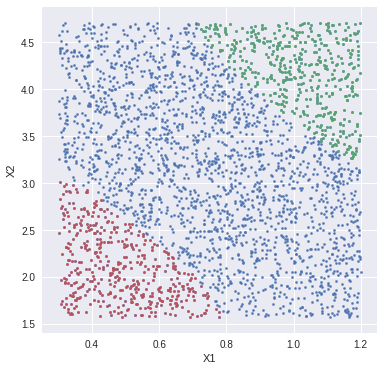

In [11]:
plot_2d([theta_train, theta_only_region_A, theta_only_region_C], s=5)

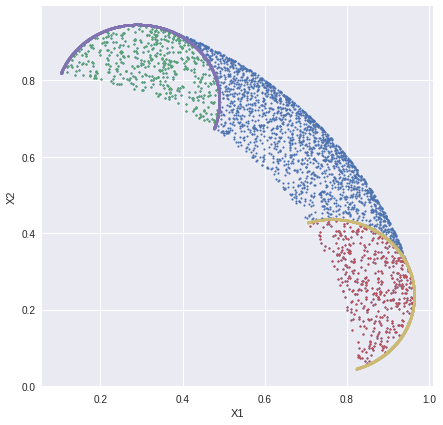

In [12]:
plot_2d([x_train, x_only_region_A, x_only_region_C, x_regionA, x_regionC],
         figsize=(7,7), s=3)

## Train simple Neural Network

Let's build a simple feed-forward neural network with tanh activation to try and learn an input-to-output mapping.

<!--An important note about the loss- --><!--We want to use the mean squared error between the actual and predicted outputs as our loss. The problem is that the squared error is probably not a good way for comparing two angle pairs. Each angle in the pair can be chosen from a circular range of values, and so the combined space of values looks like [a donut, also called 2-torus](https://observablehq.com/@renatoppl/torus-knots).-->

<!--In the paper, the loss is not taken directly between the original and predicted angles. Instead the predicted angles are first run through the forward kinematics equations to get a predicted end effector position. The loss is then defined as the mean of the squared error between each input and predicted end effector position.-->

In [0]:
def build_simple_NN(n_hidden_units, l1, l2):
    x = Input(shape=(2,)) # Fed Input
    t = Input(shape=(2,)) # Fed Output
    hidden = Dense(n_hidden_units, activation=tf.nn.tanh)(x)
    t_out = Dense(2, activation=None)(hidden)
    t1, t2 = tf.split(t_out, 2, axis=1)
    x1 = l1*tf.math.cos(t1) - l2*tf.math.cos(t1 + t2)
    x2 = l1*tf.math.sin(t1) - l2*tf.math.sin(t1 + t2)
    x_out = tf.concat([x1, x2], axis=1)
    loss = tf.losses.mean_squared_error(t, t_out)
    train_op = tf.train.AdamOptimizer().minimize(loss)
    return x, t, x_out, t_out, loss, train_op
    
def train_simple_NN(x_train_data, t_train_data, x_test_data, t_test_data,
                    l1=0.8, l2=0.2,
                    n_hidden_units=20, n_epochs=3000, batch_size=200, 
                    n_best_ckpt_every=200, ckpt_dir="mdn_simple_checkpoints",
                    should_ckpt=False,
                    should_load_ckpt=False, log_on=False):
    x, t, x_out, t_out, loss, train_op = build_simple_NN(n_hidden_units, l1, l2)
    costs = np.zeros(n_epochs)
    pred_t_bests = []
    pred_x_bests = []
    if not os.path.exists(ckpt_dir) and should_ckpt:
        os.makedirs(ckpt_dir)
    with tf.Session() as sess:
        best_cost = 10000000.0
        sess.run(tf.global_variables_initializer())
        if should_load_ckpt:
            load_checkpoint(sess, ckpt_dir)
        for i in range(n_epochs):
            #idx = np.random.permutation(range(0, N))[0:batch_size]
            #s, c = sess.run([train_ops, cost], feed_dict={t:t_data[idx], 
            #                                              x:x_data[idx]})
            s, c = sess.run([train_op, loss], feed_dict={x:x_train_data,
                                                         t:t_train_data})
            costs[i] = c
            if (i + 1) % n_best_ckpt_every == 0:
                if log_on:
                    print(str(i+1) + ", Cost: " + str(c))
                if c < best_cost:
                    best_cost = c
                    if should_ckpt:
                        save_model(sess, ckpt_dir, i, log_on)
                    pred_t, pred_x = sess.run([t_out, x_out], 
                                              feed_dict={x: x_test_data,
                                                         t: t_test_data})
                    pred_t_bests.append(pred_t)
                    pred_x_bests.append(pred_x)
        return costs, pred_t_bests, pred_x_bests

In [0]:
# Run if you want to delete existing ckpts
#!rm -rf mdn_simple_checkpoints/

In [15]:
simple_NN_costs, simple_NN_t_test_pred_bests, simple_NN_x_test_pred_bests = \
    train_simple_NN(x_train, theta_train, x_test, theta_test, 
                    L1, L2, n_hidden_units=20, 
                    n_epochs=10000, n_best_ckpt_every=1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


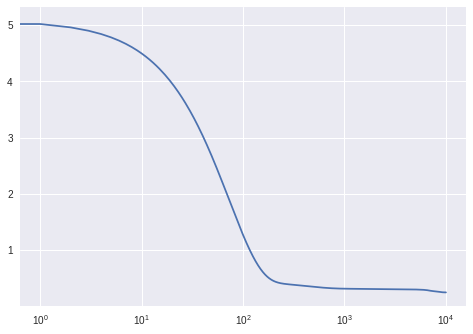

In [16]:
# Plot the loss
plt.semilogx(simple_NN_costs);   

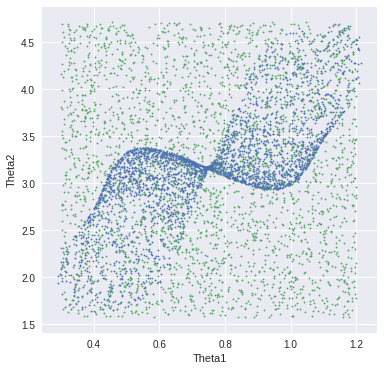

In [17]:
# Plot the predicted thetas against the actual thetas
plot_2d([simple_NN_t_test_pred_bests[-1], theta_test], 
        xlabel="Theta1", ylabel="Theta2", s=2)

We can plot the displacement from each actual test position to the position  obtained after running the predicted angles through the forward kinematics equations. If we have a good model, the resulting and original end effector positions should be very close and so the displacements should be very small.

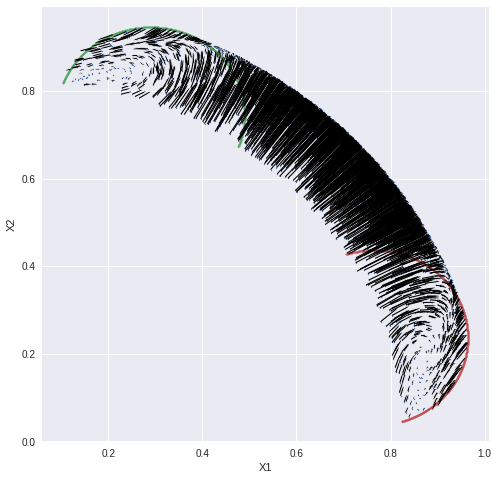

In [18]:
# Plot the displacements
simple_NN_x_test_pred_arrows = simple_NN_x_test_pred_bests[-1] - x_test
plot_2d([x_test, x_regionA, x_regionC], [x_test, simple_NN_x_test_pred_arrows], 
        figsize=(8,8), s=1, q_headaxislength=1, q_units='xy', q_scale=1)

In [19]:
print("The RMS error is", np.mean(np.sqrt(np.sum(np.square(simple_NN_x_test_pred_arrows), axis=1))))

The RMS error is 0.04355835398048099


As we can see, the displacements are quite large everywhere, suggesting that our model is not able to effectively predict the joint angles for a given end effector position. 

Note that the predictions are not quite as bad in regions A and C, and this makes a little sense if we remember that for regions A and C, the inverse kinematics problem has just one joint configuration for a given end effector position, so it is slightly easier for the neural network to approximate the mapping there.


## Neural Nets only approximate conditional average

The reason we have large displacements in general is two-fold
1. Conventional feed-forward neural nets only approximate the conditional average of the output given the input when minimizing sum-of-squares. 

    Or conversely, if the conditional density of the output given the input is assumed Gaussian, output variables are assumed to be i.i.d, and training data is drawn i.i.d, then maximizing the likelihood of seeing the data w.r.t the parameters of the input-to-output function (a.k.a weights of a neural net) results in the sum-of-squares objective, and the at the MLE weights the network's prediction approximates the conditional average of the output given the input.

2. Additionally, the residual error in the MLS/MLE formulation approximates the variance of $p(y|x)$. Clearly, this variance is global and does not depend on $x$.

But as we have seen before for our inverse kinematics problem, there are some input end effector positions that can be achieved using 2 joint angle configurations i.e. both the 'elbow up' and reflected 'elbow down' configurations.

Also, from contrasting between the distinct regions (A, C and the rest) in the above plots, it's clear that the variance of the output is not the same for every input.

So it would be cool if our network could approximate not just the conditional average of the output given the input, but an entire conditional distribution for the output given the input that can capture how both the conditional average and variance of the output possibly changes for the input. We could then sample from this distribution to get values that hopefully correspond to the possibly multiple outputs for a given input.

## Enter Mixture Density Networks

Whereas a conventional NN approximates the conditional average of the output $y$ given the input $x$, a Mixture Density Network is a neural network that approximates the conditional probability distribution $p(y|x)$ of the output $y$ given the input $x$. 

Instead of modeling $p(y|x)$ as a Gaussian, it is modeled as a Mixture Model with the general form $p(y|x) = \sum_{i=1}^{M} \pi_i(x) \phi_i(y|x; \theta_i(x))$, and the MDN is tasked with learning the parameters $\pi_i, \theta_i$ that maximize the likelihood of seeing the training data as before.

The "network" in MDN arises from the fact that the parameters of the mixture model $\pi_i, \theta_i$ are themselves parameterized by the weights $W$ of a feed-forward neural network. That is $\pi_i(x) = \pi_i(x;W)$, $\theta_i = \theta_i(x;W)$. <!-- - notice the similarity to $y=f(x;W)$ in MLS section above.--> To learn $\pi_i, \theta_i$ we maximize the likelihood of the data w.r.t $W$.

Typically $\phi_i$ are Gaussian kernels, resulting in the familiar Gaussian Mixture Model (GMM). Thus, a typical MDN combines a feed-forward network with a GMM. When an input is fed into a such an MDN, it outputs the parameters $\pi_i, \theta_i$ of the GMM: the $\pi_i(x;W)$ are the mixing coefficients as before; each $\theta_i(x;W)$ consists of the $k$-dimensional mean vector $\mu_i(x;W)$ and $k$ variances $\sigma_i(x;W)$ (assuming covariances are 0), where $k$ is the dimensionality of $y$. The learned $\pi_i$, $\theta_i$ can, for example, be used to instantiate a GMM which can be sampled from to produce an output value.

[David Ha's 2015 post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) already touches on the theory in good detail, and also goes over the inverse sinusoidal example in section 5 of the paper, using the then version of tensorflow.

## Create the Mixture Density Network

Alright, let's make ourselves an MDN!

Note: `diag_cov == True` signifies that we don't want any off-diagonal covariance terms in our Gaussian kernels.
In principle, given the correct number of feed-forward inputs and Gaussian kernels, the MDN should be able to model arbitrary density functions even if the Gaussians are strictly diagonal. I have found that this may not be true in practice, although I need to do a more exhaustive search over hyperparameters to validate that claim.

## Train the Mixture Density Network

Note: I was unable to reproduce the result in the paper. I found that the MDN can separate out the 3 regions (A, B, C in the paper) relatively well, but that the displacement from the actual positions was too large (even larger than the simple NN). 

In a desperate attempt to get somewhere, I tried combining the likelihood loss with the squared error loss, with both constant and annealed weights. For the annealing, I trying decreasing the weight of the likelihood loss while keeping the squared loss constant and also while increasing the squared loss. The idea behind this was: Let the likelihood loss first "spread" the $(\theta_1, \theta_2)$ outputs into their correct general spots, and then let the squared loss drive them to their exact spots.

Anyway none of the above seemed to do much good. I'm sure I'm making a  mistake somewhere in the code.

In [0]:
# Stole from https://github.com/eyalzk/sketch_rnn_keras
class WeightScheduler(keras.callbacks.Callback):
    """Weight scheduler.
    # Arguments
        weight: The tensor withholding the current KL weight term
        schedule: a function that takes a batch index as input
            (integer, indexed from 0) and returns a new learning rate as output (float).
        verbose: int. 0: quiet, 1: update messages.
    """

    def __init__(self, weight, schedule, verbose=0):
        super(WeightScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose
        self.weight = weight
        self.count = 0  # Global batch index (the regular batch argument refers to the batch index within the epoch)

    def on_batch_begin(self, batch, logs=None):

        new_weight = self.schedule(self.count)
        if not isinstance(new_weight, (float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        # Set new value
        K.set_value(self.weight, new_weight)
        if self.verbose > 0 and self.count % 20 == 0:
            print('\nBatch %05d: WeightScheduler setting KL weight '
                  ' to %s.' % (self.count + 1, new_weight))
        self.count += 1

In [0]:
def make_scheduler_cbk(params, weight_var, verbose=1):
    """This decays the weight"""
    custom_scheduler_cbk = WeightScheduler(schedule=lambda step:
        (max(params['weight_start'], 
             (params['weight'] * params['decay_rate']) ** step)
        ), weight=weight_var, verbose=verbose)
    return custom_scheduler_cbk
  
# Stole from https://github.com/eyalzk/sketch_rnn_keras
def make_scheduler_cbk_inc(params, weight_var, verbose=1):
    """This increase upto the weight"""
    custom_scheduler_cbk = WeightScheduler(schedule=lambda step:
        (params['weight'] - (params['weight'] - params['weight_start']) * 
         params['decay_rate'] ** step
        ), weight=weight_var, verbose=verbose)
    return custom_scheduler_cbk

In [0]:
W_MLE_PARAMS = {
    'weight': 1.0,
    'weight_start': 0.01,
    'decay_rate': 0.99999
}

In [0]:
def custom_loss(output_dim, num_mixes, w_mle_variable, w_mse_variable):
    """Linear combination of MLE loss and MSE loss."""
    def loss_func(y_true, y_pred):
        mle = (mdn.get_mixture_loss_func(output_dim, num_mixes))(y_true, y_pred)
        mse = (mdn.get_mixture_mse_accuracy(output_dim, num_mixes))(y_true, 
                                                                    y_pred)
        mle_w = tf.multiply(w_mle_variable, mle)
        mse_w = tf.multiply(w_mse_variable, mse)
        return tf.add(mle_w, mse_w)
    
    return loss_func

In [0]:
def build_and_train_model(
    x_train_data, t_train_data, x_test_data, t_test_data,
    n_hidden_units=10, n_out_units=8, n_mix_comps=2,
    w_mle_params={'weight':1.0, 'weight_start': 0.01, 'decay_rate': 0.05},
    n_epochs=6000, batch_size=200, should_load_ckpt=False, verbose=1):
    """Builds and trains the MDN model."""
    
    OUTPUT_DIMS = x_train_data.shape[-1]
    
    # Make a variable for the annealed mle weight
    w_mle_variable = K.variable(w_mle_params['weight_start'], name='w_mle')
    w_mse_variable = K.variable(w_mle_params['weight_start'], name='w_mse')
    
    # Use the params and variable for making the scheduler
    scheduler_cbk = make_scheduler_cbk(params=w_mle_params,
                                       weight_var=w_mle_variable,
                                       verbose=verbose)
    scheduler_cbk_inc = make_scheduler_cbk_inc(params=w_mle_params,
                                               weight_var=w_mse_variable,
                                               verbose=verbose)
    # Build the model
    model = keras.Sequential()
    model.add(keras.layers.Dense(n_hidden_units, batch_input_shape=(None, 2), 
                                 activation='relu'))
    model.add(keras.layers.Dense(n_out_units, activation='relu'))
    model.add(mdn.MDN(OUTPUT_DIMS, n_mix_comps))
    # Note: This is the loss, can put variables here for annealing.
    model.compile(loss=custom_loss(OUTPUT_DIMS,n_mix_comps,w_mle_variable,
                                   1.0), 
                  optimizer=keras.optimizers.Adam())
    model.summary()
    
    if should_load_ckpt:
        model.load_weights("mdn_model.h5")
    
    # Train the model (1 line, keras is dope)
    history = model.fit(x=x_train_data, y=t_train_data, 
                        batch_size=batch_size, epochs=n_epochs,
                        validation_split=0.15, verbose=0,
                        callbacks=[keras.callbacks.TerminateOnNaN(),
                                   scheduler_cbk, scheduler_cbk_inc])
    return model, history

In [0]:
N_HIDDEN_UNITS= 40
N_OUT_UNITS= 40
N_MIXES = 64
OUTPUT_DIMS = 2

In [71]:
mdn_model, mdn_history = build_and_train_model(
    x_train, theta_train, x_test, theta_test,
    n_hidden_units=N_HIDDEN_UNITS, n_out_units=N_OUT_UNITS, n_mix_comps=N_MIXES,
    w_mle_params=W_MLE_PARAMS,
    n_epochs=3000, batch_size=800, should_load_ckpt=False, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                120       
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
mdn_5 (MDN)                  (None, 320)               13120     
Total params: 14,880
Trainable params: 14,880
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (17.140975). Check your callbacks.
  % delta_t_median)


In [0]:
#mdn_model.save_weights("mdn_model.h5")

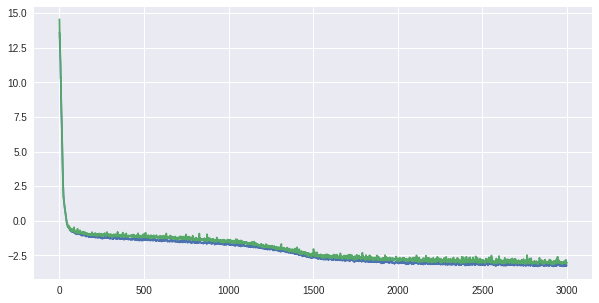

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(mdn_history.history['loss'])
plt.plot(mdn_history.history['val_loss'])

In [0]:
# Predict gmm params for test positions.
t_test_pred = mdn_model.predict(x_test)

In [0]:
# Sample from gmm
t_samples = np.apply_along_axis(mdn.sample_from_output, 1, arr=t_test_pred,
                                output_dim=OUTPUT_DIMS, num_mixes=N_MIXES,
                                temp=0.01)
t_samples = t_samples.reshape((-1,2))

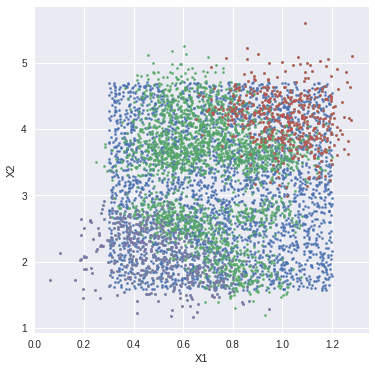

In [76]:
plot_2d([theta_test, t_samples, t_samples[test_region_ids_A], t_samples[test_region_ids_C]],s=5)

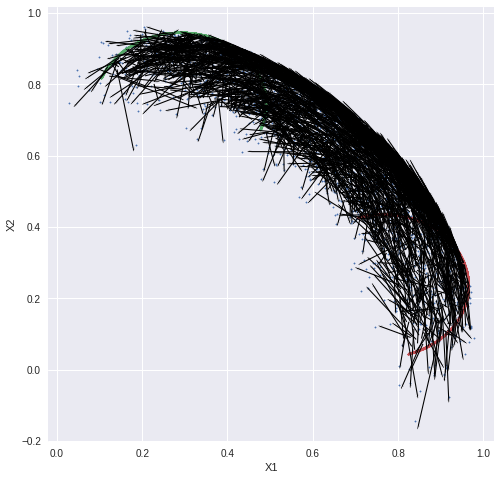

In [77]:
SHOW_TRUNCATED_ONLY = False

mdn_x_pred, mdn_y_pred = fk_solve(t_samples[:,0],
                                  t_samples[:,1],
                                  l1=L1, l2=L2)
mdn_xy_pred = np.concatenate([mdn_x_pred.reshape(-1,1), 
                              mdn_y_pred.reshape(-1,1)], axis=1)
mdn_disps = mdn_xy_pred - x_test

if SHOW_TRUNCATED_ONLY:
    trunc_disps = []
    trunc_xy_pred = []
    trunc_x_test = []
    for i in range(N):
        if t_samples[i,0] > theta1_range[0] and \
           t_samples[i,0] < theta1_range[1] and \
           t_samples[i,1] > theta2_range[0] and \
           t_samples[i,1] < theta2_range[1] and \
           np.sum(np.square(mdn_disps[i])) < 0.001:
            trunc_disps.append(list(mdn_disps[i]))
            trunc_xy_pred.append(list(mdn_xy_pred[i]))
            trunc_x_test.append(list(x_test[i]))

    trunc_disps = np.array(trunc_disps)
    trunc_xy_pred = np.array(trunc_xy_pred)
    trunc_x_test = np.array(trunc_x_test)

    plot_2d(datas=[trunc_xy_pred, x_regionA, x_regionC],
            quiver_lst=[trunc_x_test, trunc_disps], 
            q_headaxislength=1, q_units='xy', q_scale=1,
            figsize=(8,8))
else:
    plot_2d([mdn_xy_pred, x_regionA, x_regionC],
            quiver_lst=[x_test, mdn_disps],
            q_headaxislength=1, q_units='xy', q_scale=1,
            figsize=(8,8))

In [78]:
print("The RMS error is", np.mean(np.sqrt(np.sum(np.square(mdn_disps), axis=1))))

The RMS error is 0.070124167703135


## Report

So clearly I am not doing a good job of reproducing the main MDN result from the paper. The MDN seems to learn the distinction between the 3 "regions" - A, B and C. But it's not approximating the region B and the hard edges very well. Also while the $\theta$'s seem to be in the general regions, they are quite displaced from their true positions.

Possible reasons for failure to reproduce:
1. Something wrong in my implementation.
2. Something wrong in my implementation.
3. Maybe Adam is not good here, and BFGS should have been used.
4. Seems like the model is still learning even at the end of training, so maybe just increase to like 1 million epochs (lol).
5. Possibly the Gaussian kernel, but the paper did just fine with it.

## Implementation notes

### Differences from paper

1. I use 3000 points instead of 1000.
2. For training both the preliminary feed-forward NN and the MDN, I use the AdamOptimizer instead of BFGS.
3. For the feed-forward NN, I used 10000 epochs instead of 3000 cycles used in the paper.
4. For the MDN, I use 40 hidden units, 40 output units, 64 mixture components,  instead of 10 hidden units, 8 output units, 2 mixture components used in the paper. Also tried custom losses where I linearly combined the likelihood loss and the squared loss, even annealing the weight (down and up respectively).


### Coding specifics

1. I implement the mixture model using the [Keras MDN Layer](https://github.com/cpmpercussion/keras-mdn-layer) (which relies TensorFlow Probability).
    
    Underneath the hood, the Keras MDN layer leverages [Categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) for the mixing coefficients, [MultivariateNormalDiag](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag) for constructing multivariate gaussian components from means and diagonal covariance matrices, and [Mixture](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Mixture) for constructing the mixture model using the probabilities and components. This spares us from having to code up things like the Bivariate Gaussian kernel, the Mixture sampling etc. because we can just defer to TFP for these things. On the downside, we probably
 1. lose some efficiency because we are not providing a closed-form version of the kernel ourselves,
 2. lose some control over abating numerical precision problems, and so every once in a while during training/evaluation we will get an error due to a malformed covariance matrix. (But there are tricks in [Alex Brando's Masters Thesis](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation) to help alleviate this challenge, which are employed in Keras MDN Layer.)